In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import seaborn as sns
import plotly.express as px
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor, RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.compose import make_column_selector as selector
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, RandomizedSearchCV, cross_val_predict, cross_validate, GridSearchCV, train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler

import warnings
warnings.filterwarnings('ignore')

import shap
shap.initjs()


df_normal_quality = pd.read_csv('dataframes/df_normal_quality.csv', index_col= 0).reset_index(drop = True)
y = df_normal_quality.SalePrice
X = df_normal_quality.drop(['SalePrice', 'PID'], axis =1).copy()

kf = KFold(n_splits=5, shuffle=True, random_state=42)
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)
numerical_columns = numerical_columns_selector(X)
categorical_columns = categorical_columns_selector(X)


# LASSO

In [28]:
categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")               

numerical_preprocessor = RobustScaler()


preprocessor = ColumnTransformer(
    [
        ("robust_scaler", numerical_preprocessor, numerical_columns),
        ("one-hot-encoder", categorical_preprocessor, categorical_columns),
    ]
)



lasso_pipe = Pipeline(steps=[("Preprocess", preprocessor), 
                             ("Regressor", TransformedTargetRegressor(regressor = Lasso(alpha = 0.0003059499593517016),
                                                                func =np.log, inverse_func=np.exp))])

                         
scores = cross_val_score(lasso_pipe, X, y, cv = kf, error_score='raise')

print('Lasso')

lasso_std = scores.std()
lasso_score = scores.mean()

print('score', lasso_score)
print('standard deviation', lasso_std)
print('      ')

lasso_pipe.fit(X,y)

lasso_predictions = lasso_pipe.predict(X)
print('predicted prices', lasso_predictions)

lasso_mae = mean_absolute_error(y, lasso_predictions)
print('Mean Absolute Error:', lasso_mae)

lasso_mpv = lasso_predictions.mean()
print ('Mean Predicted Home Value', lasso_mpv)

mhv = y.mean()
print ('Mean  Home Value', mhv)
print('      ')

Lasso
score 0.9508125679921836
standard deviation 0.004995965282436691
      
predicted prices [125415.46689604 130117.07504741 115860.94910926 ... 153060.14400882
 224551.71100964 223786.68230574]
Mean Absolute Error: 10279.818581988946
Mean Predicted Home Value 172915.24056661013
Mean  Home Value 173427.01285897984
      


# SHAP

In [29]:
lasso_pipe.fit(X,y)

explainer_lasso_log = shap.LinearExplainer(lasso_pipe.named_steps['Regressor'].regressor_,
                          masker = lasso_pipe.named_steps['Preprocess'].transform(X))

# Calculate SHAP values for the transformed test set
shap_values_lass_log = explainer_lasso_log(lasso_pipe.named_steps['Preprocess'].transform(X))

# Get feature names after transformation
transformed_feature_names = lasso_pipe.named_steps['Preprocess'].get_feature_names_out()

# Convert SHAP values and transformed data to DataFrame for easier manipulation
# transform Explanation type into a df with named columns 
shap_values_df_lasso_log = pd.DataFrame(shap_values_lass_log.values, columns=transformed_feature_names)

categorical_prefixes = categorical_columns_selector(X)
categorical_prefixes = ["one-hot-encoder__" + word for word in categorical_prefixes]
categorical_prefixes

for prefix in categorical_prefixes:
    # Get columns that start with the prefix
    columns = [col for col in transformed_feature_names if col.startswith(prefix)]
    
    # Calculate mean SHAP value for these columns
    shap_values_df_lasso_log[prefix] = shap_values_df_lasso_log[columns].sum(axis=1)
    
    # Drop the individual encoded columns
    shap_values_df_lasso_log.drop(columns=columns, inplace=True)

# Get rid of prefixes
shap_values_df_lasso_log.columns = shap_values_df_lasso_log.columns.str.replace('robust_scaler__', 
                                                                    '', 
                                                                    regex=False)
shap_values_df_lasso_log.columns = shap_values_df_lasso_log.columns.str.replace('one-hot-encoder__', 
                                                                    '', 
                                                                    regex=False)

# reorder X columns so the original values are in the same order as the shap df
X_new_order = list(numerical_columns) + list(categorical_columns)
X_new_order =X[X_new_order]

observations = range(shap_values_df_lasso_log.shape[0])
dollar_shap_df_lasso = pd.DataFrame(columns=X_new_order.columns)
order = X_new_order.columns

for observation in observations:
    shap_values = shap_values_df_lasso_log.iloc[observation].reindex(shap_values_df_lasso_log.iloc[observation].abs().sort_values().index)
    features = shap_values.index.tolist()
    values = shap_values.values.tolist()
    bv = shap_values_lass_log.base_values[1]
    SHAPs = values
    changes = []
    
    for shaps in SHAPs:
        changes.append((np.exp(bv + shaps) - np.exp(bv)))
        bv = bv + shaps 
        
    df_change = pd.DataFrame({'Feature': features, 'Change': changes})
    df_change = df_change.set_index('Feature').T
    df_ordered_changes = df_change[order]
    dollar_shap_df_lasso.loc[observation] = df_ordered_changes.iloc[0]

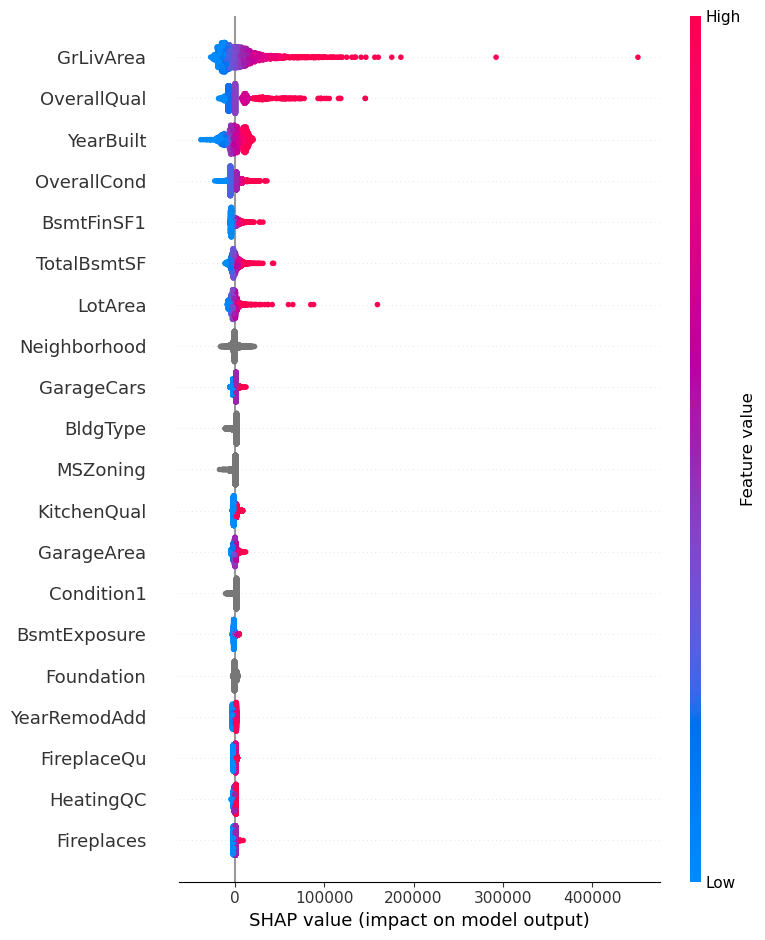

In [30]:
# Create a shap.Explanation with scaled shap values and correct feature names 
exp_lasso = shap.Explanation(dollar_shap_df_lasso.values, 
                       np.exp(shap_values_lass_log.base_values),
                       X_new_order)

shap.summary_plot(exp_lasso)

# XGB

In [5]:
categorical_preprocessor_OHE = OneHotEncoder(handle_unknown="ignore", drop = None)
categorical_preprocessor_O =  OrdinalEncoder(handle_unknown="use_encoded_value", 
                                           unknown_value= -1)
numerical_preprocessor = StandardScaler()

preprocessor_OHE = ColumnTransformer(
    [
        ("standard_scaler", numerical_preprocessor, numerical_columns),
        ("encoder", categorical_preprocessor_OHE, categorical_columns),
    ]
)

preprocessor_O = ColumnTransformer(
    [
        ("standard_scaler", numerical_preprocessor, numerical_columns),
        ("encoder", categorical_preprocessor_O, categorical_columns),
    ]
)


xgb_OHE =  XGBRegressor(max_depth= 4,
                    learning_rate= 0.04643973848790804,
                    subsample= 0.5797329944770706,
                    colsample_bytree= 0.527504939004116,
                    n_estimators= 905,
                    min_child_weight= 3)

xgb_O = XGBRegressor(max_depth= 4,
                    learning_rate= 0.044081018318051106,
                    subsample= 0.5797329944770706,
                    colsample_bytree= 0.5330333973787846,
                    n_estimators= 917,
                    min_child_weight= 2)


xgb_pipe_OHE = Pipeline(steps=[("Preprocess", preprocessor_OHE), 
                               ("Regressor", TransformedTargetRegressor(regressor =xgb_OHE,
                                                                          func =np.log, inverse_func=np.exp))])
                          

xgb_pipe_O = Pipeline(steps=[("Preprocess", preprocessor_O), ("XGB", xgb_O)])


scores_OHE = cross_val_score(xgb_pipe_OHE, X, y, cv = kf, error_score='raise')


scores_O = cross_val_score(xgb_pipe_O, X, y, cv = kf, error_score='raise')


print('XGB OneHot')
xgb_score = scores_OHE.mean()
xgb_std = scores_OHE.std()
print('score', xgb_score)
print('standard deviation', xgb_std)

xgb_pipe_OHE.fit(X,y)

xgb_OHE_predictions = xgb_pipe_OHE.predict(X)
print('predicted prices', xgb_OHE_predictions)

xgb_OHE_mae = mean_absolute_error(y, xgb_OHE_predictions)
print('Mean Absolute Error:', xgb_OHE_mae)

xgb_OHE_mpv = xgb_OHE_predictions.mean()
print ('Mean Predicted Home Value', xgb_OHE_mpv)

mhv = y.mean()
print ('Mean  Home Value', mhv)

print('         ')
print('XGB Ordinal')
print('score', scores_O.mean())
print('standard deviation', scores_O.std())

xgb_pipe_O.fit(X,y)

xgb_O_predictions = xgb_pipe_O.predict(X)
print('predicted prices', xgb_O_predictions)

xgb_O_mae = mean_absolute_error(y, xgb_O_predictions)
print('Mean Absolute Error:', xgb_O_mae)

xgb_O_mpv = xgb_O_predictions.mean()
print ('Mean Predicted Home Value', xgb_O_mpv)

mhv = y.mean()
print ('Mean  Home Value', mhv)

XGB OneHot
score 0.9538790152827454
standard deviation 0.004298267507064383
predicted prices [123684.31  136620.55  121025.016 ... 144983.69  219554.66  219634.23 ]
Mean Absolute Error: 4284.175757809151
Mean Predicted Home Value 173185.95
Mean  Home Value 173427.01285897984
         
XGB Ordinal
score 0.9520954039217431
standard deviation 0.00400626352265317
predicted prices [123697.734 137102.42  121085.1   ... 145562.38  224346.8   214692.53 ]
Mean Absolute Error: 3958.2779866989927
Mean Predicted Home Value 173431.39
Mean  Home Value 173427.01285897984


# XGB SHAP
# One hot encoded

In [6]:
xgb_pipe_OHE.fit(X,y)
# This is the same code as Lasso one hot combined but for xgb one hot 
explainer_xgb = shap.Explainer(xgb_pipe_OHE.named_steps['Regressor'].regressor_,
                          masker = xgb_pipe_OHE.named_steps['Preprocess'].transform(X))

# Calculate SHAP values for the transformed test set
shap_values_xgb = explainer_xgb(xgb_pipe_OHE.named_steps['Preprocess'].transform(X))

# Get feature names after transformation
transformed_feature_names = xgb_pipe_OHE.named_steps['Preprocess'].get_feature_names_out()

# Convert SHAP values and transformed data to DataFrame for easier manipulation
# transform Explanation type into a df with named columns 
shap_values_df_xgb_log = pd.DataFrame(shap_values_xgb.values, 
                                      columns=transformed_feature_names)
    
categorical_prefixes = categorical_columns_selector(X)
categorical_prefixes = ["encoder__" + word for word in categorical_prefixes]

for prefix in categorical_prefixes:
    # Get columns that start with the prefix
    columns = [col for col in transformed_feature_names if col.startswith(prefix)]
    
    # Calculate mean SHAP value for these columns
    shap_values_df_xgb_log[prefix] = shap_values_df_xgb_log[columns].sum(axis=1)
    
    # Drop the individual encoded columns
    shap_values_df_xgb_log.drop(columns=columns, inplace=True)
# Get rid of prefixes
shap_values_df_xgb_log.columns = shap_values_df_xgb_log.columns.str.replace('standard_scaler__', 
                                                                    '', 
                                                                    regex=False)
shap_values_df_xgb_log.columns = shap_values_df_xgb_log.columns.str.replace('encoder__', 
                                                                    '', 
                                                                    regex=False)

observations = range(shap_values_df_xgb_log.shape[0])
dollar_shap_df_xgb = pd.DataFrame(columns=X_new_order.columns)
order = X_new_order.columns

for observation in observations:
    shap_values = shap_values_df_xgb_log.iloc[observation].reindex(shap_values_df_xgb_log.iloc[observation].abs().sort_values().index)
    features = shap_values.index.tolist()
    values = shap_values.values.tolist()
    bv = shap_values_xgb.base_values[1]
    SHAPs = values
    changes = []
    
    for shaps in SHAPs:
        changes.append((np.exp(bv + shaps) - np.exp(bv)))
        bv = bv + shaps 
        
    df_change = pd.DataFrame({'Feature': features, 'Change': changes})
    df_change = df_change.set_index('Feature').T
    df_ordered_changes = df_change[order]
    dollar_shap_df_xgb.loc[observation] = df_ordered_changes.iloc[0]



100%|===================| 2331/2333 [01:09<00:00]        

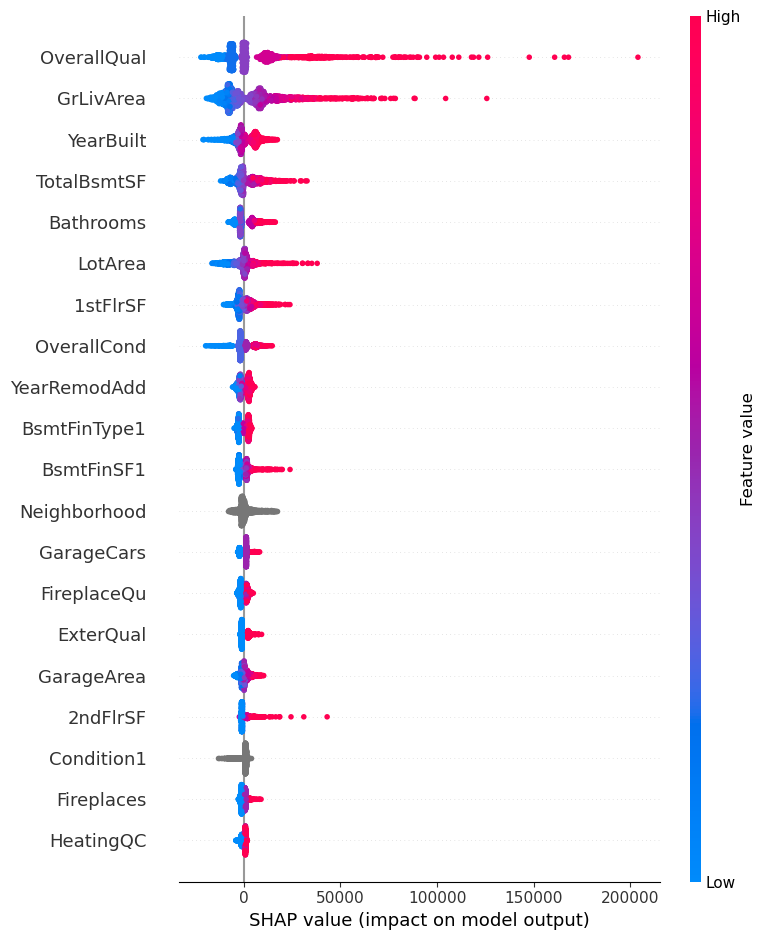

In [8]:
exp_xgb_OHE = shap.Explanation(dollar_shap_df_xgb.values, 
                       np.exp(shap_values_xgb.base_values),
                       X_new_order)

shap.summary_plot(exp_xgb_OHE, max_display= 20)

In [9]:
xgb_OHE_predictions[10]

138243.52

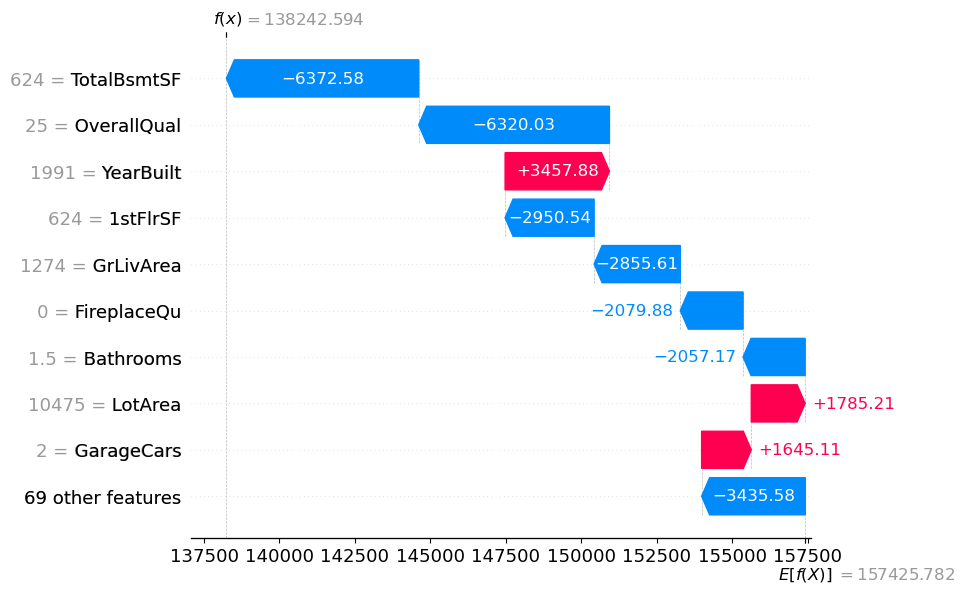

In [10]:
shap.waterfall_plot(exp_xgb_OHE[10])

# XGB SHAP 
## Ordinal encoded

 99%|===================| 2311/2333 [01:10<00:00]        

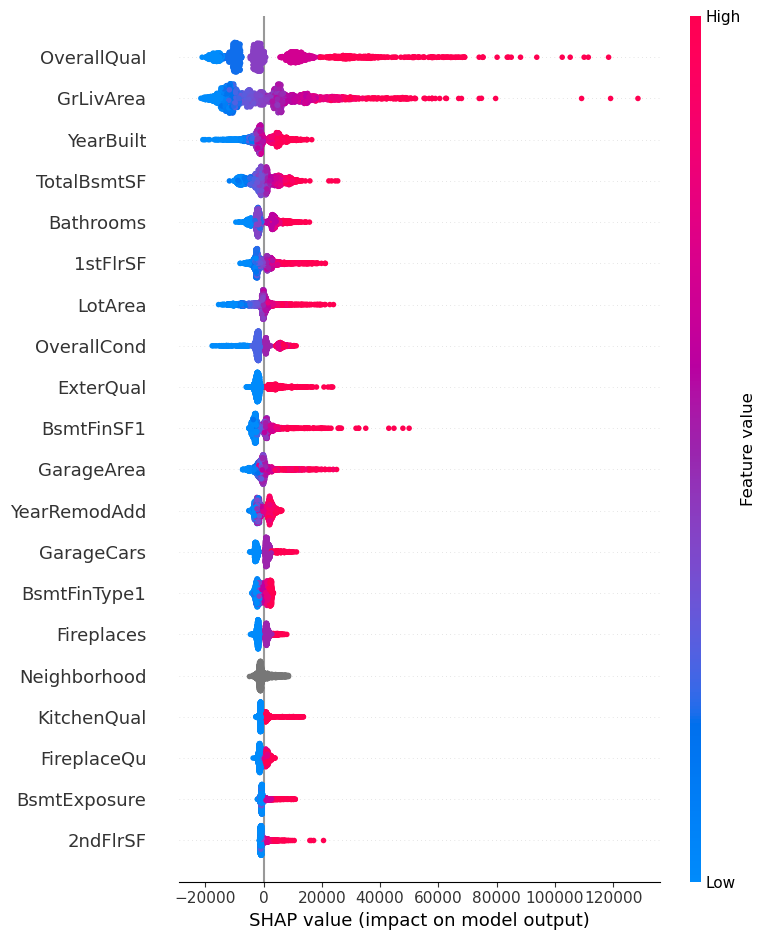

In [11]:
xgb_pipe_O.fit(X,y)

explainer_xgb_o = shap.Explainer(xgb_pipe_O.named_steps['XGB'],
                          masker = xgb_pipe_O.named_steps['Preprocess'].transform(X))

# Calculate SHAP values for the transformed test set
shap_values_xgb_o = explainer_xgb_o(xgb_pipe_O.named_steps['Preprocess'].transform(X))

# Get feature names after transformation
transformed_feature_names = xgb_pipe_O.named_steps['Preprocess'].get_feature_names_out()

# Convert SHAP values and transformed data to DataFrame for easier manipulation
# transform Explanation type into a df with named columns 
shap_values_df_xgb_o = pd.DataFrame(shap_values_xgb_o.values, columns=transformed_feature_names)

shap_values_df_xgb_o.columns = shap_values_df_xgb_o.columns.str.replace('standard_scaler__', 
                                                                    '', 
                                                                    regex=False)
shap_values_df_xgb_o.columns = shap_values_df_xgb_o.columns.str.replace('encoder__', 
                                                                    '', 
                                                                    regex=False)

exp_xgb_O = shap.Explanation(shap_values_df_xgb_o.values, 
                           shap_values_xgb_o.base_values, 
                           X_new_order
                         )

shap.summary_plot(exp_xgb_O, max_display= 20)

In [12]:
xgb_O_predictions[10]

135833.05

In [13]:
y[10]

136000

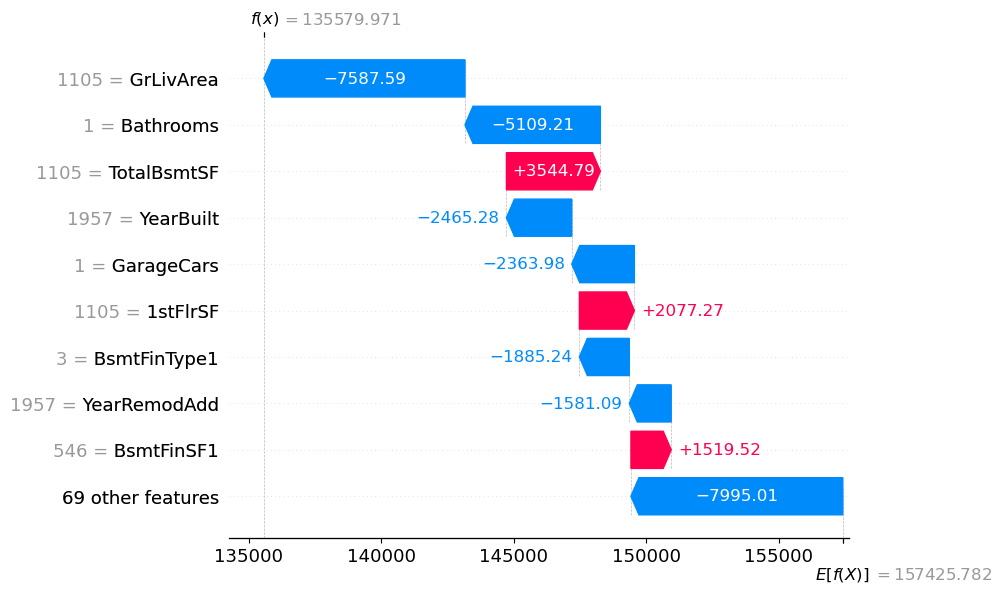

In [14]:
shap.waterfall_plot(exp_xgb_OHE[100])

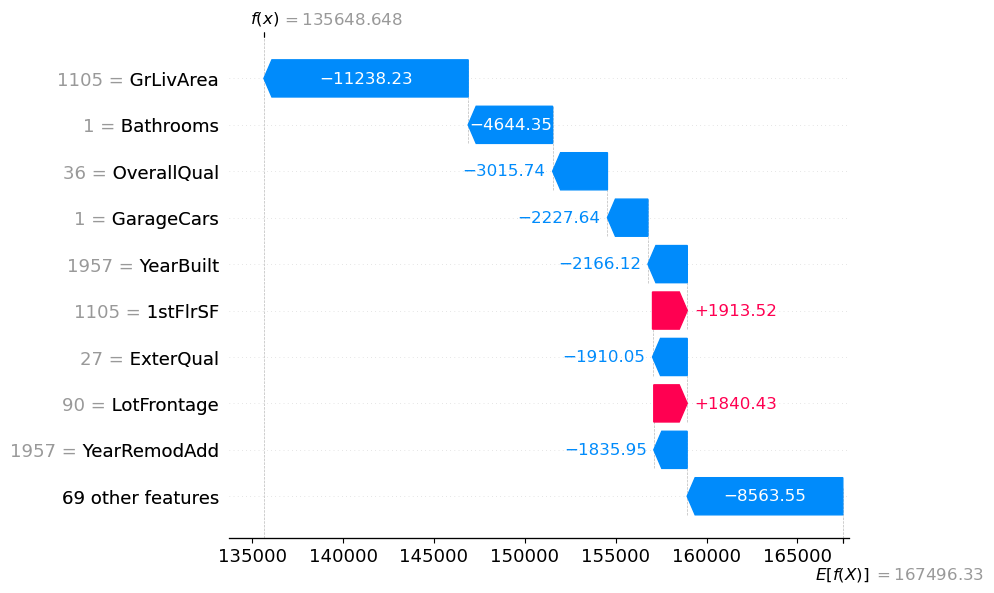

In [15]:
shap.waterfall_plot(exp_xgb_O[100])

# Comparing Lasso and XGB

In [31]:
df_predictions = df_normal_quality.copy()
df_predictions['Lasso'] = lasso_predictions
df_predictions['error_Lasso'] = df_predictions.SalePrice - df_predictions.Lasso
df_predictions['xgb'] = xgb_OHE_predictions
df_predictions['error_xgb'] = df_predictions.SalePrice - df_predictions.xgb
df_predictions[['SalePrice', 'Lasso',  'error_Lasso', 'xgb','error_xgb']]

SalePrice          Lasso   error_Lasso            xgb     error_xgb
0        126000  125415.466896    584.533104  123684.312500   2315.687500
1        139500  130117.075047   9382.924953  136620.546875   2879.453125
2        124900  115860.949109   9039.050891  121025.015625   3874.984375
3        114000  105119.599868   8880.400132  112510.101562   1489.898438
4        227000  223692.819190   3307.180810  213293.171875  13706.828125
...         ...            ...           ...            ...           ...
2328     121000  107054.707286  13945.292714  119838.703125   1161.296875
2329     139600  122905.260713  16694.739287  138721.578125    878.421875
2330     145000  153060.144009  -8060.144009  144983.687500     16.312500
2331     217500  224551.711010  -7051.711010  219554.656250  -2054.656250
2332     215000  223786.682306  -8786.682306  219634.234375  -4634.234375

[2333 rows x 5 columns]

In [32]:
data = pd.DataFrame({
    'GrLivArea': X['GrLivArea'],
    'OverallQual': X['OverallQual'],
    'Error': y - lasso_predictions
})

# Create the plot
fig = px.scatter(
    data, x='GrLivArea', y='Error',
    color=np.sqrt(X.OverallQual), 
    title=f'Lasso: Living Area vs. Prediction Error<br><sup>R2:{lasso_score:.4f} / std: {lasso_std:.4f} / Mean Absolute Error: ${lasso_mae:.2f}</sup>',
    labels={'GrLivArea': 'Above Ground Living Area (Square Feet)', 
            'Error': 'Error ($)',
            'color': ''},
    color_continuous_scale='Turbo'
)

# Add a horizontal line at y=0
fig.add_shape(type="line",
              x0=min(data['GrLivArea']), x1=max(data['GrLivArea']),
              y0=0, y1=0,
              line=dict(color="red", dash="dash"))


fig.update_layout(
    yaxis_range=[-100000, 100000],
    yaxis_title_standoff=0,
    height = 700, 
    width = 700
)

fig.add_annotation(
    x=1.1,  # Adjust the x position as needed
    y=1.1,  # Adjust the y position as needed
    text="Overall<br>Quality",  # Custom legend title with line break
    showarrow=False,
    xref="paper",
    yref="paper",
    align="left",
    font=dict(size=13)
)
# Show plot
fig.show()

fig.write_image("images/lasso_error.png")

In [33]:
data = pd.DataFrame({
    'GrLivArea': X['GrLivArea'],
    'OverallQual': X['OverallQual'],
    'Error': y - xgb_OHE_predictions
})

# Create the plot
fig = px.scatter(
    data, x='GrLivArea', y='Error',
    color=np.sqrt(X.OverallQual), 
    title=f'XGB: Living Area vs. Prediction Error<br><sup>R2: {xgb_score:.4f} / std: {xgb_std:.4f} / Mean Absolute Error: ${xgb_OHE_mae:.2f}</sup>',
    labels={'GrLivArea': 'Above Ground Living Area (Square Feet)', 
            'Error': 'Error ($)', 
            'color': ''},
    color_continuous_scale='Turbo'
)

# Add a horizontal line at y=0
fig.add_shape(type="line",
              x0=min(data['GrLivArea']), x1=max(data['GrLivArea']),
              y0=0, y1=0,
              line=dict(color="red", dash="dash"))

fig.update_layout(
    yaxis_range=[-100000, 100000],
    yaxis_title_standoff=0,
    height = 700, 
    width = 700
)

fig.add_annotation(
    x=1.1,  # Adjust the x position as needed
    y=1.1,  # Adjust the y position as needed
    text="Overall<br>Quality",  # Custom legend title with line break
    showarrow=False,
    xref="paper",
    yref="paper",
    align="left",
    font=dict(size=13)
)

# Show plot
fig.show()

fig.write_image("images/xgb_error.png")

# Neighborhood

In [34]:
# Sort the data by shap_values_df_lasso_comb.Neighborhood
sorted_indices = dollar_shap_df_lasso.Neighborhood.argsort()
sorted_neighborhoods = X.Neighborhood[sorted_indices]
sorted_shap_values_lasso = dollar_shap_df_lasso.Neighborhood[sorted_indices]
sorted_shap_values_xgb = dollar_shap_df_xgb.Neighborhood[sorted_indices]

# Create traces
trace1 = go.Scatter(
    x=sorted_neighborhoods,
    y=sorted_shap_values_xgb,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x=sorted_neighborhoods,
    y=sorted_shap_values_lasso,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Neighborhood SHAP Values',
    xaxis=dict(title='Neighborhood'),
    yaxis=dict(title='SHAP Values ($)'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()



In [35]:
# Sort the data by shap_values_df_lasso_comb.Neighborhood
sorted_indices = dollar_shap_df_lasso.Neighborhood.argsort()
sorted_neighborhoods = X.Neighborhood[sorted_indices]
sorted_shap_values_lasso = shap_values_df_lasso_log.Neighborhood[sorted_indices]
sorted_shap_values_xgb = shap_values_df_xgb_log.Neighborhood[sorted_indices]

# Create traces
trace1 = go.Scatter(
    x=sorted_neighborhoods,
    y=sorted_shap_values_xgb,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x=sorted_neighborhoods,
    y=sorted_shap_values_lasso,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Neighborhood SHAP Values',
    xaxis=dict(title='Neighborhood'),
    yaxis=dict(title='SHAP Values ($)'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()



In [21]:
fig = px.scatter(
    x=X.Neighborhood, 
    y=dollar_shap_df_xgb.Neighborhood, 
    color = np.sqrt(X.OverallQual),
    labels={'x': 'Overall Quality', 'y': 'Neighborhood SHAP Values'},
    title='Neighborhood vs Neighborhood SHAP Values'
)

# Show the plot
fig.show()

In [22]:
fig = px.scatter(
    x=X.Neighborhood, 
    y=dollar_shap_df_lasso.Neighborhood, 
    color = np.sqrt(X.OverallQual),
    labels={'x': 'Overall Quality', 'y': 'Neighborhood SHAP Values'},
    title='Neighborhood vs Neighborhood SHAP Values'
)

# Show the plot
fig.show()

In [24]:
color = X.Neighborhood

color_transformed = []
for word in color:
    if word == 'Crawfor':
        color_transformed.append('Crawfor')
    elif word == 'Somerst':
        color_transformed.append('StoneBr')
    elif word == 'BrkSide':
        color_transformed.append('BrkSide')
    elif word == 'ClearCr':
        color_transformed.append('ClearCr')
    else:
        color_transformed.append('other')
    
fig = px.scatter(
    x=np.sqrt(X.OverallQual), 
    y=dollar_shap_df_lasso.Neighborhood, 
    color = color_transformed,
    labels={'x': 'Overall Quality', 'y': 'Neighborhood SHAP Values'},
    title='Overall Quality vs Neighborhood SHAP Values'
) 

# Show the plot
fig.show()

# Living Area

In [23]:
trace1 = go.Scatter(
    x= X.GrLivArea,
    y=shap_values_df_xgb_log.GrLivArea,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x= X.GrLivArea,
    y= shap_values_df_lasso_log.GrLivArea,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Living Area SHAP Values',
    xaxis=dict(title='Above Ground Living Area (Square Feet)'),
    yaxis=dict(title='SHAP Values'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

In [25]:
trace1 = go.Scatter(
    x= X.GrLivArea,
    y=dollar_shap_df_xgb.GrLivArea,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x= X.GrLivArea,
    y= dollar_shap_df_lasso.GrLivArea,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Living Area SHAP Values',
    xaxis=dict(title='Above Ground Living Area (Square Feet)'),
    yaxis=dict(title='SHAP Values'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

In [159]:
df_predictions.loc[df_predictions.GrLivArea > 3500]

PID  GrLivArea  SalePrice  MSSubClass MSZoning  LotFrontage  \
807   528351010       4316     755000          60       RL        104.0   
1116  528320060       3627     625000          60       RL        118.0   
1777  902400110       3608     475000          75       RM         90.0   

      LotArea Street  Alley  LotShape  ...  Fence  MoSold YrSold  SaleType  \
807     21535   Pave    0.0         2  ...     NO       1   2007       WD    
1116    35760   Pave    0.0         2  ...     NO       7   2006       WD    
1777    22950   Pave    0.0         3  ...  GdPrv       6   2006       WD    

     SaleCondition Bathrooms          Lasso   error_Lasso         xgb  \
807         Normal       4.0  839574.083156 -84574.083156  740903.000   
1116        Normal       4.5  656745.473393 -31745.473393  635433.875   
1777        Normal       2.5  420286.769298  54713.230702  463887.625   

      error_xgb  
807   14097.000  
1116 -10433.875  
1777  11112.375  

[3 rows x 84 columns]

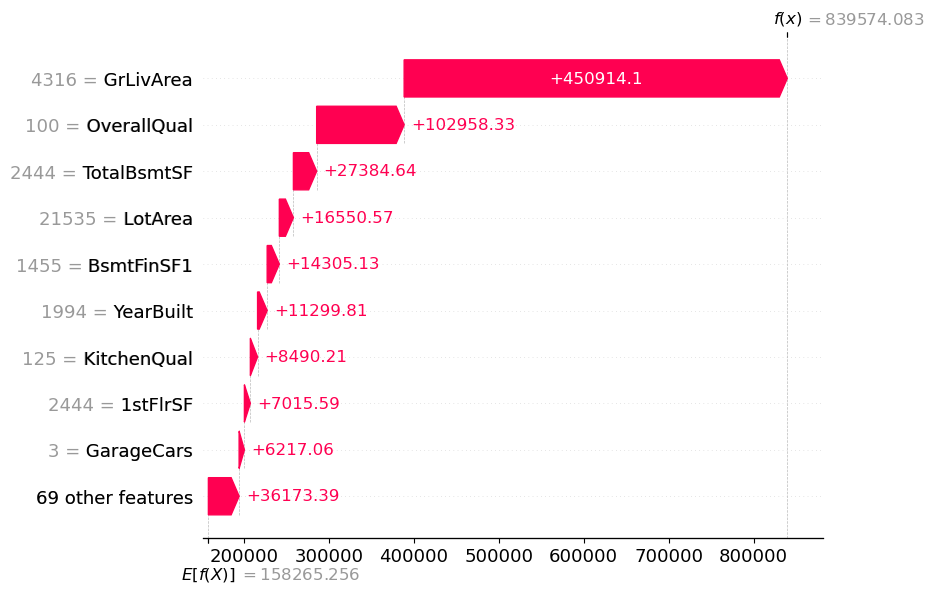

In [26]:
shap.waterfall_plot(exp_lasso[807])

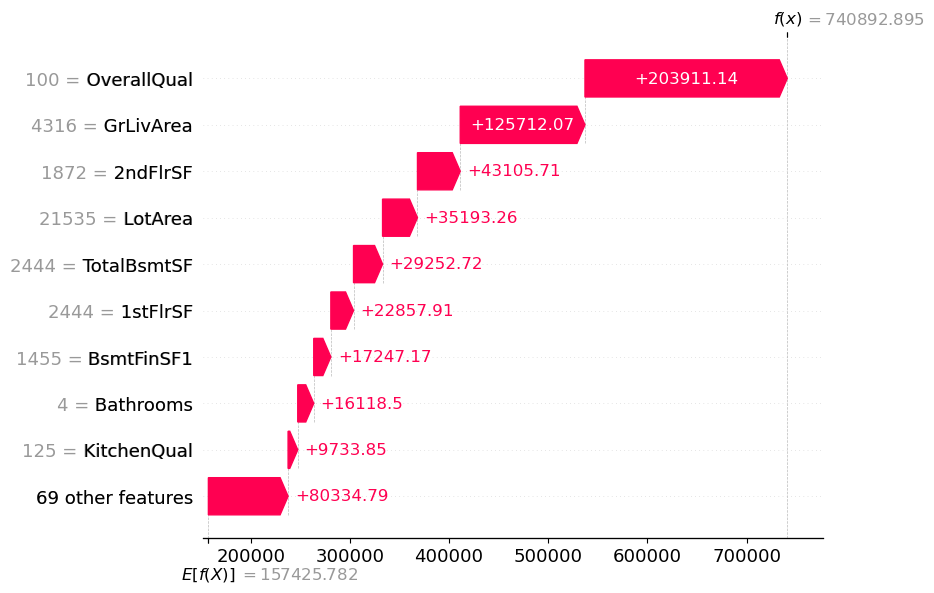

In [27]:
shap.waterfall_plot(exp_xgb_OHE[807])

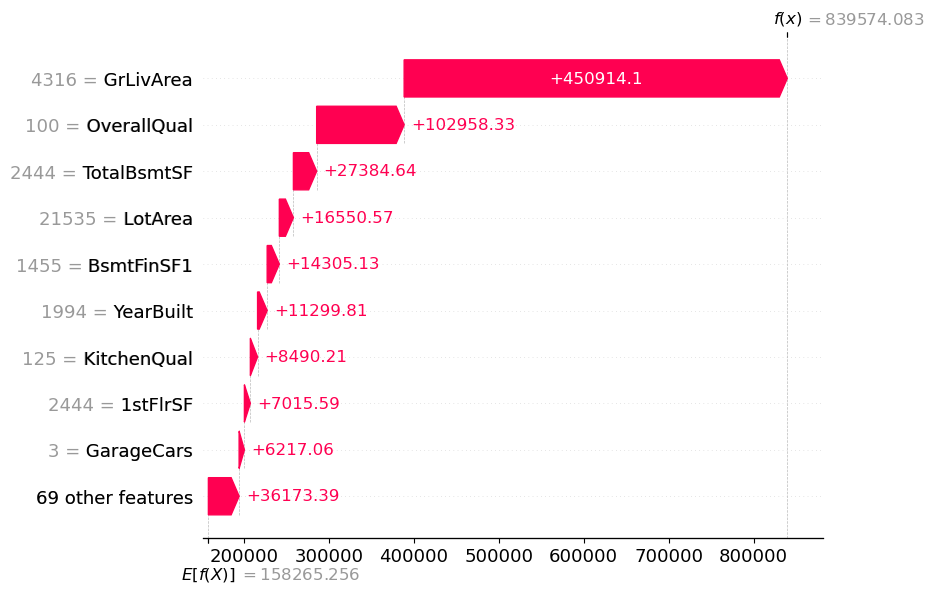

In [157]:
shap.waterfall_plot(exp_lasso[807])

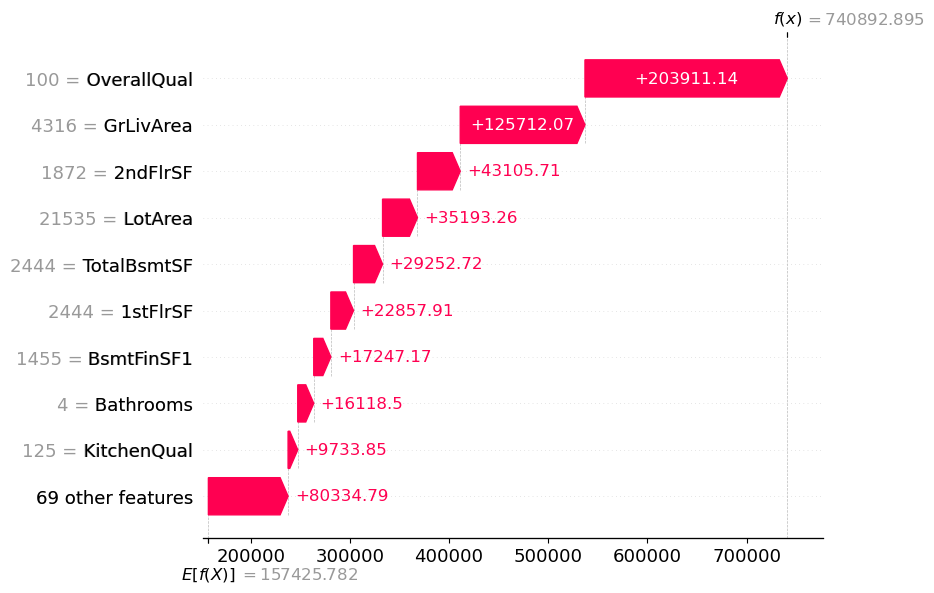

In [158]:
shap.waterfall_plot(exp_xgb_OHE[807])

# Overall Quality

In [140]:
trace1 = go.Scatter(
    x=X.OverallQual,
    y=shap_values_df_xgb_log.OverallQual,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x= X.OverallQual,
    y= shap_values_df_lasso_log.OverallQual,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Quality SHAP Values',
    xaxis=dict(title='Quality'),
    yaxis=dict(title='SHAP Values ($)'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

In [141]:
trace1 = go.Scatter(
    x=X.OverallQual,
    y=dollar_shap_df_xgb.OverallQual,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x= X.OverallQual,
    y= dollar_shap_df_lasso.OverallQual,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Quality SHAP Values',
    xaxis=dict(title='Quality'),
    yaxis=dict(title='SHAP Values ($)'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

In [145]:
trace1 = go.Scatter(
    x=X.LotArea,
    y=shap_values_df_xgb_log.LotArea,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x= X.LotArea,
    y= shap_values_df_lasso_log.LotArea,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Lot Area SHAP Values',
    xaxis=dict(title='Lot Area (square feet)'),
    yaxis=dict(title='SHAP Values ($)'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

In [146]:
trace1 = go.Scatter(
    x=X.LotArea,
    y=dollar_shap_df_xgb.LotArea,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x= X.LotArea,
    y= dollar_shap_df_lasso.LotArea,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Lot Area SHAP Values',
    xaxis=dict(title='Lot Area (square feet)'),
    yaxis=dict(title='SHAP Values ($)'),
)


fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

In [148]:

trace1 = go.Scatter(
    x=X.GarageCars,
    y=shap_values_df_xgb_log.GarageCars,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x= X.GarageCars,
    y= shap_values_df_lasso_log.GarageCars,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Garage Cars SHAP Values',
    xaxis=dict(title='Cars'),
    yaxis=dict(title='SHAP Values'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

In [149]:

trace1 = go.Scatter(
    x=X.GarageCars,
    y=dollar_shap_df_xgb.GarageCars,
    mode='markers',
    name='XGB'
)
trace2 = go.Scatter(
    x= X.GarageCars,
    y= dollar_shap_df_lasso.GarageCars,
    mode='markers',
    name='Lasso'
)

# Create the layout
layout = go.Layout(
    title='Garage Cars SHAP Values',
    xaxis=dict(title='Cars'),
    yaxis=dict(title='SHAP Values'),
)

fig = go.Figure(data=[trace1, trace2], layout=layout)

fig.show()

In [150]:
import plotly.express as px
from plotly.subplots import make_subplots

# Create a subplot with 1 row and 2 columns
fig = make_subplots(rows=2, cols=2, subplot_titles=("log", "Dollars"))

# First scatter plot
scatter1 = px.scatter(
    x=shap_values_df_xgb_log.GrLivArea,
    y=shap_values_df_xgb_log.OverallQual,
    color=np.sqrt(X.OverallQual), 
    title='Living Area SHAP vs. Overall Quality SHAP',
    color_continuous_scale='Turbo'
).update_traces(showlegend=False)

# Second scatter plot
scatter2 = px.scatter(
    x=dollar_shap_df_xgb.GrLivArea,
    y=dollar_shap_df_xgb.OverallQual,
    color=np.sqrt(X.OverallQual), 
    title='Living Area SHAP vs. Overall Quality SHAP',
    color_continuous_scale='Turbo'
).update_traces(showlegend=False)

scatter3 = px.scatter(
    x=shap_values_df_lasso_log.GrLivArea,
    y=shap_values_df_lasso_log.OverallQual,
    color=np.sqrt(X.OverallQual), 
    title='Living Area SHAP vs. Overall Quality SHAP',
    color_continuous_scale='Turbo'
).update_traces(showlegend=False)

# Second scatter plot
scatter4 = px.scatter(
    x=dollar_shap_df_lasso.GrLivArea,
    y=dollar_shap_df_lasso.OverallQual,
    color=np.sqrt(X.OverallQual), 
    title='Living Area SHAP vs. Overall Quality SHAP',
    color_continuous_scale='Turbo'
).update_traces(showlegend=False)

# Add scatter plots to the subplot
for trace in scatter1.data:
    fig.add_trace(trace, row=1, col=1)

for trace in scatter2.data:
    fig.add_trace(trace, row=1, col=2)
    
for trace in scatter3.data:
    fig.add_trace(trace, row=2, col=1)

for trace in scatter4.data:
    fig.add_trace(trace, row=2, col=2)

# Update layout
fig.update_layout(title_text="Comparison of SHAP for XGB Dollars vs. Log Dollars")

# Show the plot
fig.show()
